In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.special import expit
from scipy.stats import binom
from py_scripts.common import QuantitiesOfInterest
from py_scripts.plotting import heatmap
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

# Prepare the data

In [2]:
data = pd.read_csv('challenger_data.csv')
data = data.dropna()
data = data.drop(24)
df_original = pd.DataFrame({
    "x": data.Temperature,
    "y": data["Damage Incident"].astype(int)
})
offset = df_original.x.mean().round()
df = df_original.copy()
df["x"] = df.x - offset

# Conventional Logistic Regression

In [3]:
formula = 'y ~ x'
results = smf.logit(formula, data=df).fit(disp=False)
results.params

Intercept   -1.208490
x           -0.232163
dtype: float64

# Bayesian Logistic Regression
## Estimate the parameters

In [4]:
# Hypothesis space of parameters
hs_m = np.linspace(-.8, .1, 101)  # slope
hs_x0 = np.linspace(-5, 1, 101)  # intercept

# Create all possible pairs of parameters in a flat array
mesh_m, mesh_x0 = np.meshgrid(hs_m, hs_x0)
mesh_m = mesh_m.ravel()
mesh_x0 = mesh_x0.ravel()

# We will need trials and failures to compute the binomial distribution, therefore we need
# to group by x
observations = df.groupby('x').y.agg(["count", "sum"])  # size 16
observations.rename(columns={"count": "ns", "sum": "ks"}, inplace=True)

# We will need three arrays of 101^2 x 16 for ks, ns and ps
# For ks and ns is quite straigthforward, just get the relevant mesh from the meshgrid
# with one of the parameters mesh
ks_mesh, _ = np.meshgrid(observations.ks, mesh_m)  # 10201 x 16
ns_mesh, _ = np.meshgrid(observations.ns, mesh_m)

# For ps it's a bit more tricky as we need three arrays to compute expit that needs three
# parameters
vx, v_m = np.meshgrid(observations.index, mesh_m)
_, v_x0 = np.meshgrid(observations.index, mesh_x0)
p_mesh = expit(v_x0 + v_m * vx)

# Finally compute the binomial for all the combinations and take the joint probability
dist = binom.pmf(k=ks_mesh, n=ns_mesh, p=p_mesh)
likes = dist.prod(axis=1)

# build the bayes table
k = pd.DataFrame({
    "x0": mesh_x0.round(2),
    "m":mesh_m.round(3),
    "likes": likes,
    "posterior": likes / likes.sum()
})

## Plot the posterior

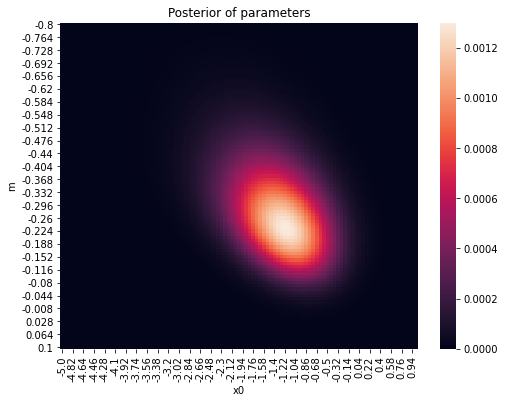

In [5]:
# To extract the marginals we need to pivot the table to a 101 x 101 array
posterior = k.pivot(index="m", columns="x0", values="posterior")
heatmap(posterior, title="Posterior of parameters")

# Transformation & Marginals

The expected value is: 0.7542914170110268
The MAP is: 0.7850561775518295
The CI is: [0.5939263245834361, 0.8985256729903055]
The expected value is: 0.22019378846479876
The MAP is: 0.2175502235768875
The CI is: [0.0731011734223782, 0.4061268970658573]


((101,), (101,))

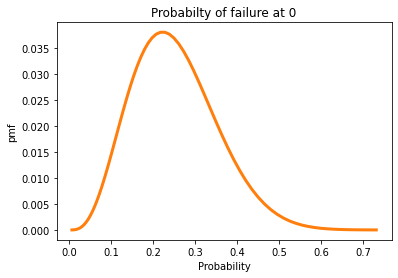

In [6]:
# Extract the marginals
marginal_m = posterior.sum(axis=1)
marginal_x0 = posterior.sum()

marginal_m /= marginal_m.sum()
marginal_x0 /= marginal_x0.sum()

# Transform Them
marginal_m.index = np.exp(marginal_m.index)
marginal_x0.index = expit(marginal_x0.index)

q_m = QuantitiesOfInterest(marginal_m)
q_x0 = QuantitiesOfInterest(marginal_x0)
[klass.run() for klass in (q_m, q_x0)]

marginal_x0.plot(
    title="Probabilty of failure at 0", 
    xlabel="Probability", ylabel="pmf", color="C1", lw="3"
);
marginal_m.shape, marginal_x0.shape

# Predictive Posterior

In [7]:
# Lets do some sampling
s_post = posterior.stack().reset_index()
s = s_post.sample(100, weights=s_post[0])

t_range = np.arange(observations.index.min() -25, observations.index.max() + 2)

# Now we need to compute the probability of each pair of parameters for the range of
# temperatures, so we will need meshes of the elements.
sm_mesh, t_mesh = np.meshgrid(s.m.values, t_range)
sx0_mesh, _ = np.meshgrid(s.x0.values, t_range)
model = expit(sx0_mesh + sm_mesh * t_mesh)

# Find the percentiles for each temperature
percentiles = {"lo": 5, "mid": 50, "hi": 95}
data = np.percentile(model, [p for p in percentiles.values()], axis=1)

# Finally build the df containing the three percentiles for each temperature.
data = pd.DataFrame(
    data,
    columns=t_range + offset,
    index=percentiles.keys(),
).T

In [8]:

# Create data sources
s0, s1 = [ColumnDataSource(source) for source in (data, df_original)]

p = figure(
    width=600, height=350, 
    title="Posterior Probability of Failure",
    x_axis_label="Temp in ºF", y_axis_label="Probability of Failure",
    tooltips='@index: @lo, @mid, @hi'
)

p.line(x='index', y='mid', source=s0, color="orange", line_width=3)
p.varea(x='index', y1='lo', y2='hi', color="orange", source=s0, alpha=.5, )
p.circle(x='x', y="y", source=s1, size=10, alpha=.3)

show(p)